This is just going to train a simple model using the converted images.
It's very similar to the [first lesson of fastai](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson1-pets.ipynb).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [61]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
from tqdm import tqdm_notebook as tqdm
from src.paths import TRAIN_FOLDER, TEST_FOLDER, SUBMISSION_CSV

In [3]:
label_pattern = r'/([^/]+)_\d+.jpg$'
BATCH_SIZE=4

In [11]:
np.random.seed(2)
data = ImageDataBunch.from_name_re(
    path=TRAIN_FOLDER,
    fnames=get_image_files(TRAIN_FOLDER),
    pat=label_pattern,
    ds_tfms=get_transforms(do_flip=False),
    size=224,
    bs=BATCH_SIZE
).normalize(imagenet_stats)

In [12]:
help(get_transforms)

Help on function get_transforms in module fastai.vision.transform:

get_transforms(do_flip: bool = True, flip_vert: bool = False, max_rotate: float = 10.0, max_zoom: float = 1.1, max_lighting: float = 0.2, max_warp: float = 0.2, p_affine: float = 0.75, p_lighting: float = 0.75, xtra_tfms: Union[Collection[fastai.vision.image.Transform], NoneType] = None) -> Collection[fastai.vision.image.Transform]
    Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms.



In [13]:
help(ImageDataBunch.from_name_re)

Help on method from_name_re in module fastai.vision.data:

from_name_re(path: Union[pathlib.Path, str], fnames: Collection[pathlib.Path], pat: str, valid_pct: float = 0.2, **kwargs) method of builtins.type instance
    Create from list of `fnames` in `path` with re expression `pat`.



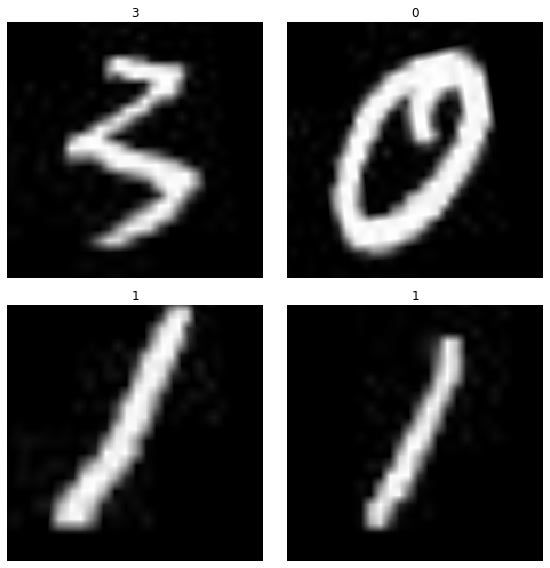

In [14]:
data.show_batch()

In [15]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/matthew/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:17<00:00, 4896548.09it/s]


In [16]:
learn.fit_one_cycle(4)

In [17]:
learn.save('r34-stage-1')

Lets try again with a smaller network! We can also avoid scaling the images.

In [4]:
np.random.seed(2)
data = ImageDataBunch.from_name_re(
    path=TRAIN_FOLDER,
    fnames=get_image_files(TRAIN_FOLDER),
    pat=label_pattern,
    ds_tfms=get_transforms(do_flip=False),
    size=28,
    bs=BATCH_SIZE
).normalize(imagenet_stats)

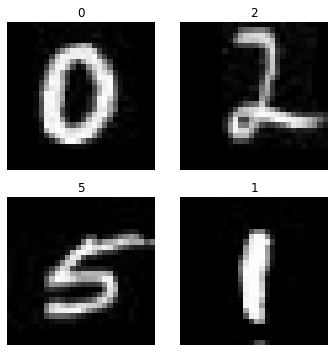

In [5]:
data.show_batch(rows=3, figsize=(5,5))

In [7]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/matthew/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:33<00:00, 1388765.59it/s]


In [8]:
learn.fit_one_cycle(4)

In [9]:
learn.save('r18-stage-1')

Now lets try with resnet 50 which should be good enough to get 100% accuracy.

In [14]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-03
Min loss divided by 10: 4.37E-04


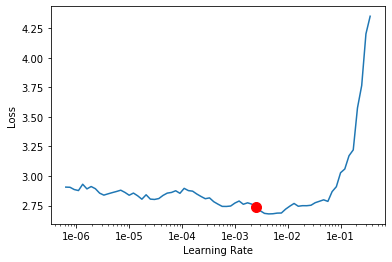

In [12]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [15]:
learn.fit_one_cycle(4, max_lr=2.51E-03)

In [16]:
learn.save('r50-stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.20E-04


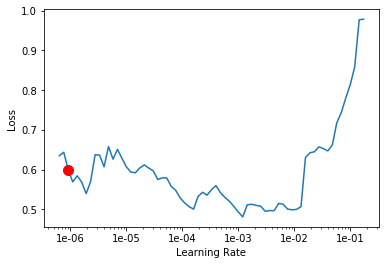

In [17]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [18]:
learn.fit_one_cycle(4, max_lr=1.20E-04)

In [19]:
learn.save('r50-stage-1-2')

Using resnet 18 and resnet 50 has not produced the same accuracy as resnet 34. This may be because of the lack of scaling. Lets try restoring that.

In [20]:
np.random.seed(2)
data = ImageDataBunch.from_name_re(
    path=TRAIN_FOLDER,
    fnames=get_image_files(TRAIN_FOLDER),
    pat=label_pattern,
    ds_tfms=get_transforms(do_flip=False),
    size=224,
    bs=BATCH_SIZE
).normalize(imagenet_stats)

In [21]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 3.98E-03


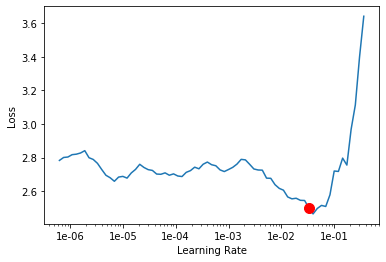

In [22]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [23]:
learn.fit_one_cycle(8, max_lr=3.31E-02)

In [24]:
learn.save('r50-224-stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Failed to compute the gradients, there might not be enough points.


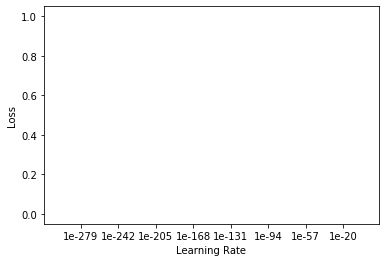

In [28]:
learn.lr_find(start_lr=1e-14)
learn.recorder.plot(suggestion=True)

In [33]:
learn.load('r50-224-stage-1')
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.58E-05


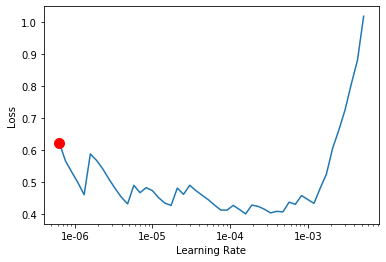

In [30]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [31]:
from fastai.callbacks import SaveModelCallback

In [34]:
end_lr = 1.58E-05
start_lr = end_lr / 9

learn.fit_one_cycle(
    8,
    max_lr=slice(start_lr, end_lr),
    callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy')]
)

In [35]:
learn.save('r50-224-stage-2')

In [36]:
??learn.predict

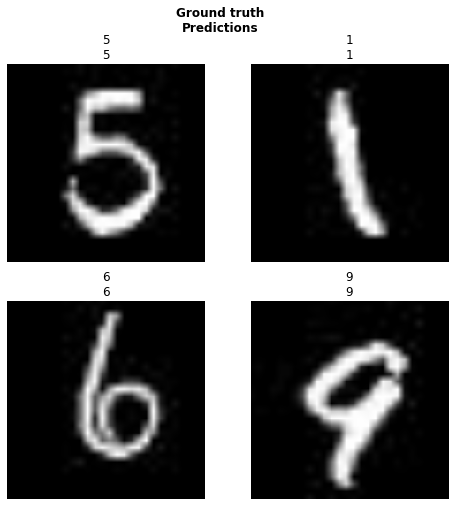

In [37]:
learn.show_results(ds_type=DatasetType.Valid)

In [44]:
sorted(TEST_FOLDER.ls())[:5]

[PosixPath('/home/matthew/Programming/Kaggle/digit-recognizer/data/processed/test/000000.jpg'),
 PosixPath('/home/matthew/Programming/Kaggle/digit-recognizer/data/processed/test/000001.jpg'),
 PosixPath('/home/matthew/Programming/Kaggle/digit-recognizer/data/processed/test/000002.jpg'),
 PosixPath('/home/matthew/Programming/Kaggle/digit-recognizer/data/processed/test/000003.jpg'),
 PosixPath('/home/matthew/Programming/Kaggle/digit-recognizer/data/processed/test/000004.jpg')]

In [58]:
def predict(model, path):
    image = open_image(path)
    prediction, _, _ = model.predict(image)
    return prediction

/home/matthew/Programming/Kaggle/digit-recognizer/data/processed/test/000000.jpg 2


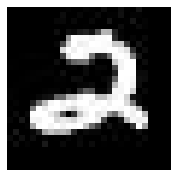

In [52]:
path = sorted(TEST_FOLDER.ls())[0]
image = open_image(path)
prediction, _, _ = learn.predict(image)
show_image(image)
print(path, prediction)

In [63]:
paths = sorted(TEST_FOLDER.ls())
ids = list(range(1, len(paths) + 1))
predictions = [
    predict(learn, path)
    for path in tqdm(paths)
]
len(ids)==len(predictions)

True

In [66]:
df = pd.DataFrame({'ImageId': ids, 'Label': predictions}).set_index('ImageId')

In [67]:
df.head()

Label
ImageId      
1           2
2           0
3           9
4           0
5           3

In [68]:
df.to_csv(SUBMISSION_CSV)

1686 Matthew Franglen 0.98271

In [71]:
preds,y = learn.get_preds(ds_type=DatasetType.Valid)
interp = ClassificationInterpretation(data, preds, y)

OSError: [Errno 24] Too many open files

In [ ]:
interp.plot_top_losses()

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
learn.save()